## Fitting a diagonal covariance Gaussian mixture model to text data

In a previous assignment, we explored k-means clustering for a high-dimensional Wikipedia dataset. We can also model this data with a mixture of Gaussians, though with increasing dimension we run into two important issues associated with using a full covariance matrix for each component.
 * Computational cost becomes prohibitive in high dimensions: score calculations have complexity cubic in the number of dimensions M if the Gaussian has a full covariance matrix.
 * A model with many parameters require more data: observe that a full covariance matrix for an M-dimensional Gaussian will have M(M+1)/2 parameters to fit. With the number of parameters growing roughly as the square of the dimension, it may quickly become impossible to find a sufficient amount of data to make good inferences.

Both of these issues are avoided if we require the covariance matrix of each component to be diagonal, as then it has only M parameters to fit and the score computation decomposes into M univariate score calculations. Recall from the lecture that the M-step for the full covariance is:

\begin{align*}
\hat{\Sigma}_k &= \frac{1}{N_k^{soft}} \sum_{i=1}^N r_{ik} (x_i-\hat{\mu}_k)(x_i - \hat{\mu}_k)^T
\end{align*}

Note that this is a square matrix with M rows and M columns, and the above equation implies that the (v, w) element is computed by

\begin{align*}
\hat{\Sigma}_{k, v, w} &= \frac{1}{N_k^{soft}} \sum_{i=1}^N r_{ik} (x_{iv}-\hat{\mu}_{kv})(x_{iw} - \hat{\mu}_{kw})
\end{align*}

When we assume that this is a diagonal matrix, then non-diagonal elements are assumed to be zero and we only need to compute each of the M elements along the diagonal independently using the following equation. 

\begin{align*}
\hat{\sigma}^2_{k, v} &= \hat{\Sigma}_{k, v, v}  \\
&= \frac{1}{N_k^{soft}} \sum_{i=1}^N r_{ik} (x_{iv}-\hat{\mu}_{kv})^2
\end{align*}

In this section, we will use an EM implementation to fit a Gaussian mixture model with **diagonal** covariances to a subset of the Wikipedia dataset. The implementation uses the above equation to compute each variance term. 

We'll begin by importing the dataset and coming up with a useful representation for each article. After running our algorithm on the data, we will explore the output to see whether we can give a meaningful interpretation to the fitted parameters in our model.

**Note to Amazon EC2 users**: To conserve memory, make sure to stop all the other notebooks before running this notebook.

## Import necessary packages

The following code block will check if you have the correct version of GraphLab Create. Any version later than 1.8.5 will do. To upgrade, read [this page](https://turi.com/download/upgrade-graphlab-create.html).

In [1]:
import graphlab

'''Check GraphLab Create version'''
from distutils.version import StrictVersion
assert (StrictVersion(graphlab.version) >= StrictVersion('1.8.5')), 'GraphLab Create must be version 1.8.5 or later.'

We also have a Python file containing implementations for several functions that will be used during the course of this assignment.

In [2]:
from em_utilities import *

## Load Wikipedia data and extract TF-IDF features

Load Wikipedia data and transform each of the first 5000 document into a TF-IDF representation.

In [3]:
wiki = graphlab.SFrame('../data/people_wiki.gl/').head(5000)
wiki['tf_idf'] = graphlab.text_analytics.tf_idf(wiki['text'])

This non-commercial license of GraphLab Create for academic use is assigned to 52151214001@stu.ecnu.edu.cn and will expire on January 24, 2018.


[INFO] graphlab.cython.cy_server: GraphLab Create v2.1 started. Logging: /tmp/graphlab_server_1504195340.log


Using a utility we provide, we will create a sparse matrix representation of the documents. This is the same utility function you used during the previous assignment on k-means with text data.

In [4]:
tf_idf, map_index_to_word = sframe_to_scipy(wiki, 'tf_idf')

As in the previous assignment, we will normalize each document's TF-IDF vector to be a unit vector. 

In [5]:
tf_idf = normalize(tf_idf)

We can check that the length (Euclidean norm) of each row is now 1.0, as expected.

In [6]:
for i in range(5):
    doc = tf_idf[i]
    print(np.linalg.norm(doc.todense()))

1.0
1.0
1.0
1.0
1.0


## EM in high dimensions

EM for high-dimensional data requires some special treatment:
 * E step and M step must be vectorized as much as possible, as explicit loops are dreadfully slow in Python.
 * All operations must be cast in terms of sparse matrix operations, to take advantage of computational savings enabled by sparsity of data.
 * Initially, some words may be entirely absent from a cluster, causing the M step to produce zero mean and variance for those words.  This means any data point with one of those words will have 0 probability of being assigned to that cluster since the cluster allows for no variability (0 variance) around that count being 0 (0 mean). Since there is a small chance for those words to later appear in the cluster, we instead assign a small positive variance (~1e-10). Doing so also prevents numerical overflow.
 
We provide the complete implementation for you in the file `em_utilities.py`. For those who are interested, you can read through the code to see how the sparse matrix implementation differs from the previous assignment. 

You are expected to answer some quiz questions using the results of clustering.

**Initializing mean parameters using k-means**

Recall from the lectures that EM for Gaussian mixtures is very sensitive to the choice of initial means. With a bad initial set of means, EM may produce clusters that span a large area and are mostly overlapping. To eliminate such bad outcomes, we first produce a suitable set of initial means by using the cluster centers from running k-means.  That is, we first run k-means and then take the final set of means from the converged solution as the initial means in our EM algorithm.

In [7]:
from sklearn.cluster import KMeans

np.random.seed(5)
num_clusters = 25

# Use scikit-learn's k-means to simplify workflow
#kmeans_model = KMeans(n_clusters=num_clusters, n_init=5, max_iter=400, random_state=1, n_jobs=-1) # uncomment to use parallelism -- may break on your installation
kmeans_model = KMeans(n_clusters=num_clusters, n_init=5, max_iter=400, random_state=1, n_jobs=1)
kmeans_model.fit(tf_idf)
centroids, cluster_assignment = kmeans_model.cluster_centers_, kmeans_model.labels_

means = [centroid for centroid in centroids]

**Initializing cluster weights**

We will initialize each cluster weight to be the proportion of documents assigned to that cluster by k-means above.

In [8]:
print len(cluster_assignment)
print cluster_assignment
print len([x for x in cluster_assignment if x==0])
print len(centroids)
print np.bincount(cluster_assignment)
print map_index_to_word
print map_index_to_word[3]

5000
[ 2 11 24 ..., 10 10 17]
45
25
[ 45 405 268 168 180  70 206 128  52 330 141 456 132 128 175 107  71 609
 154  89 136 190 206 196 358]
+---------+--------------+-------+
| feature |   category   | index |
+---------+--------------+-------+
| feature |  conflating  |   0   |
| feature |   diamono    |   1   |
| feature |   bailouts   |   2   |
| feature | electionruss |   3   |
| feature |   maywoods   |   4   |
| feature |   feduring   |   5   |
| feature |  spiderbait  |   6   |
| feature |     mcin     |   7   |
| feature |  sumiswald   |   8   |
| feature |    quinta    |   9   |
+---------+--------------+-------+
[100282 rows x 3 columns]
Note: Only the head of the SFrame is printed.
You can use print_rows(num_rows=m, num_columns=n) to print more rows and columns.
{'category': 'electionruss', 'index': 3, 'feature': 'feature'}


In [9]:
num_docs = tf_idf.shape[0]
weights = []
for i in xrange(num_clusters):
    # Compute the number of data points assigned to cluster i:
    num_assigned = np.bincount(cluster_assignment)[i] # YOUR CODE HERE
    w = float(num_assigned) / num_docs
    weights.append(w)

**Initializing covariances**

To initialize our covariance parameters, we compute $\hat{\sigma}_{k, j}^2 = \sum_{i=1}^{N}(x_{i,j} - \hat{\mu}_{k, j})^2$ for each feature $j$.  For features with really tiny variances, we assign 1e-8 instead to prevent numerical instability. We do this computation in a vectorized fashion in the following code block.

In [10]:
covs = []
for i in xrange(num_clusters):
    member_rows = tf_idf[cluster_assignment==i]
    cov = (member_rows.multiply(member_rows) - 2*member_rows.dot(diag(means[i]))).sum(axis=0).A1 / member_rows.shape[0] \
          + means[i]**2
    cov[cov < 1e-8] = 1e-8
    covs.append(cov)

**Running EM**

Now that we have initialized all of our parameters, run EM.

In [11]:
out = EM_for_high_dimension(tf_idf, means, covs, weights, cov_smoothing=1e-10)

In [12]:
out['loglik']

[3879297479.366981, 4883345753.5331306, 4883345753.5331306]

## Interpret clustering results

In contrast to k-means, EM is able to explicitly model clusters of varying sizes and proportions. The relative magnitude of variances in the word dimensions tell us much about the nature of the clusters.

Write yourself a cluster visualizer as follows.  Examining each cluster's mean vector, list the 5 words with the largest mean values (5 most common words in the cluster). For each word, also include the associated variance parameter (diagonal element of the covariance matrix). 

A sample output may be:
```
==========================================================
Cluster 0: Largest mean parameters in cluster 

Word        Mean        Variance    
football    1.08e-01    8.64e-03
season      5.80e-02    2.93e-03
club        4.48e-02    1.99e-03
league      3.94e-02    1.08e-03
played      3.83e-02    8.45e-04
...
```

In [13]:
test_argsort = [0.1,0.3,0.5,0.4]
print np.argsort(test_argsort)

[0 1 3 2]


In [14]:
# Fill in the blanks
def visualize_EM_clusters(tf_idf, means, covs, map_index_to_word):
    print('')
    print('==========================================================')

    num_clusters = len(means)
    for c in xrange(num_clusters):
        print('Cluster {0:d}: Largest mean parameters in cluster '.format(c))
        print('\n{0: <12}{1: <12}{2: <12}'.format('Word', 'Mean', 'Variance'))
        
        # The k'th element of sorted_word_ids should be the index of the word 
        # that has the k'th-largest value in the cluster mean. Hint: Use np.argsort().
        sorted_word_ids = np.argsort(means[c])[::-1]  # YOUR CODE HERE

        for i in sorted_word_ids[:5]:
            print '{0: <12}{1:<10.2e}{2:10.2e}'.format(map_index_to_word['category'][i], 
                                                       means[c][i],
                                                       covs[c][i])
        print '\n=========================================================='

In [15]:
'''By EM'''
visualize_EM_clusters(tf_idf, out['means'], out['covs'], map_index_to_word)


Cluster 0: Largest mean parameters in cluster 

Word        Mean        Variance    
poetry      1.51e-01    1.90e-02
poems       6.33e-02    6.45e-03
poet        5.91e-02    6.36e-03
de          4.77e-02    8.72e-03
literary    4.68e-02    3.29e-03

Cluster 1: Largest mean parameters in cluster 

Word        Mean        Variance    
she         1.60e-01    4.59e-03
her         1.04e-01    3.20e-03
music       1.53e-02    1.04e-03
actress     1.52e-02    1.14e-03
show        1.27e-02    7.33e-04

Cluster 2: Largest mean parameters in cluster 

Word        Mean        Variance    
football    7.45e-02    4.57e-03
club        5.84e-02    2.55e-03
league      5.72e-02    2.83e-03
season      5.06e-02    2.35e-03
played      3.79e-02    9.46e-04

Cluster 3: Largest mean parameters in cluster 

Word        Mean        Variance    
district    5.56e-02    4.00e-03
republican  5.47e-02    4.55e-03
senate      5.04e-02    5.21e-03
democratic  3.72e-02    2.46e-03
house       3.65e-02    2.07e

**Quiz1 Question**. Select all the topics that have a cluster in the model created above. [multiple choice]

> No Finance

## Comparing to random initialization

Create variables for randomly initializing the EM algorithm. Complete the following code block.

In [16]:
np.random.seed(5) # See the note below to see why we set seed=5.
num_clusters = len(means)
num_docs, num_words = tf_idf.shape

random_means = []
random_covs = []
random_weights = []

for k in range(num_clusters):
    
    # Create a numpy array of length num_words with random normally distributed values.
    # Use the standard univariate normal distribution (mean 0, variance 1).
    # YOUR CODE HERE
    mean = np.random.normal(0,1,num_words)
    
    # Create a numpy array of length num_words with random values uniformly distributed between 1 and 5.
    # YOUR CODE HERE
    cov = 4*np.random.random(num_words)+1

    # Initially give each cluster equal weight.
    # YOUR CODE HERE
    weight = 1.0/num_clusters
    
    random_means.append(mean)
    random_covs.append(cov)
    random_weights.append(weight)

**Quiz2 Question**: Try fitting EM with the random initial parameters you created above. (Use `cov_smoothing=1e-5`.) Store the result to `out_random_init`. What is the final loglikelihood that the algorithm converges to? 
> 2.3e9+

In [17]:
cov_smoothing=1e-5
out_random_init = EM_for_high_dimension(tf_idf, random_means, random_covs, random_weights, cov_smoothing=cov_smoothing)
print out_random_init.keys()
print out_random_init['loglik']
print out_random_init['loglik'][-1]
# print out_random_init

['loglik', 'resp', 'covs', 'weights', 'means']
[-764085987.57300639, 2282866699.1732855, 2362585588.3564939, 2362875609.1670547, 2362875609.1670547]


**Quiz3 Question:** Is the final loglikelihood larger or smaller than the final loglikelihood we obtained above when initializing EM with the results from running k-means?
> Initializing EM with k-means led to a smaller final loglikelihood (random is larger as is seen below)

/Users/luxi/anaconda/envs/gl-env/lib/python2.7/site-packages/matplotlib/font_manager.py:273: UserWarning: Matplotlib is building the font cache using fc-list. This may take a moment.
  warnings.warn('Matplotlib is building the font cache using fc-list. This may take a moment.')


3
Smaller


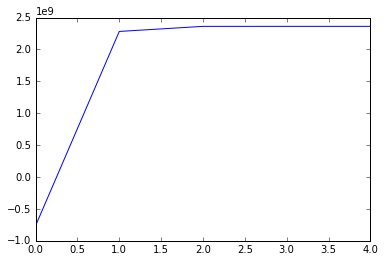

In [18]:
import matplotlib.pyplot as plt
%matplotlib inline
plt.plot(out_random_init['loglik'])

print np.argmax(out_random_init['loglik'])

print ('Larger' if out_random_init['loglik'][-1]>out['loglik'][-1] else 'Smaller')

**Quiz4 Question**: For the above model, `out_random_init`, use the `visualize_EM_clusters` method you created above. Are the clusters more or less interpretable than the ones found after initializing using k-means?

> less interpretable

In [19]:
# YOUR CODE HERE. Use visualize_EM_clusters, which will require you to pass in tf_idf and map_index_to_word.
visualize_EM_clusters(tf_idf, out_random_init['means'], out_random_init['covs'], map_index_to_word)


Cluster 0: Largest mean parameters in cluster 

Word        Mean        Variance    
she         4.21e-02    5.79e-03
her         2.63e-02    1.82e-03
music       2.03e-02    2.37e-03
singapore   1.80e-02    5.72e-03
bbc         1.20e-02    1.82e-03

Cluster 1: Largest mean parameters in cluster 

Word        Mean        Variance    
he          1.38e-02    1.11e-04
she         1.29e-02    1.67e-03
university  1.06e-02    3.19e-04
music       1.05e-02    9.94e-04
league      1.04e-02    9.58e-04

Cluster 2: Largest mean parameters in cluster 

Word        Mean        Variance    
she         3.30e-02    3.96e-03
her         2.43e-02    2.57e-03
music       1.46e-02    1.42e-03
he          1.13e-02    1.20e-04
festival    1.06e-02    2.02e-03

Cluster 3: Largest mean parameters in cluster 

Word        Mean        Variance    
she         2.69e-02    3.29e-03
her         1.76e-02    1.50e-03
film        1.43e-02    2.01e-03
series      1.04e-02    5.20e-04
he          1.00e-02    9.16e

**Note**: Random initialization may sometimes produce a superior fit than k-means initialization. We do not claim that random initialization is always worse. However, this section does illustrate that random initialization often produces much worse clustering than k-means counterpart. This is the reason why we provide the particular random seed (`np.random.seed(5)`).

## Takeaway

In this assignment we were able to apply the EM algorithm to a mixture of Gaussians model of text data. This was made possible by modifying the model to assume a diagonal covariance for each cluster, and by modifying the implementation to use a sparse matrix representation. In the second part you explored the role of k-means initialization on the convergence of the model as well as the interpretability of the clusters.